### Pipeline 2 — PCA → GRU Encoder (pre-entreno) → TCN

- El pre-entreno guardó:
  - scaler_trainonly.joblib
  - pca_trainonly.joblib
  - gru_autoencoder_pca_trainonly_best.pt 



In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet("../Limpieza_Completada/cicids2017_CleanBinary.parquet")
ts_df = pd.read_parquet("../Timestamp_Datetime_Terminado/Timestamp_Tipo_Datetime.parquet")

#Unión
df["Timestamp"] = ts_df["Timestamp"].values
#Ordenar 
df = df.sort_values("Timestamp").reset_index(drop=True)

In [3]:
#X Y
y = df["Attack"].astype(np.int64).values
#X_df = df.select_dtypes(include=[np.number]).copy()
X_df = df.select_dtypes(include=[np.number]).drop(columns=["Attack"]).copy()

In [4]:
#Split temporal (70/15/15)
n = len(df)
i_train = int(n * 0.70)
i_val   = int(n * 0.85)

X_train_df = X_df.iloc[:i_train]
X_val_df   = X_df.iloc[i_train:i_val]
X_test_df  = X_df.iloc[i_val:]

y_train = y[:i_train]
y_val   = y[i_train:i_val]
y_test  = y[i_val:]

print("X:", X_train_df.shape, X_val_df.shape, X_test_df.shape)
print("y:", y_train.shape, y_val.shape, y_test.shape)
print("train bincount:", np.bincount(y_train), " | val:", np.bincount(y_val), " | test:", np.bincount(y_test))

X: (1981377, 71) (424581, 71) (424581, 71)
y: (1981377,) (424581,) (424581,)
train bincount: [1714580  266797]  | val: [264157 160424]  | test: [294157 130424]


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_df)
X_val_sc   = scaler.transform(X_val_df)
X_test_sc  = scaler.transform(X_test_df)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_sc)
X_val_pca   = pca.transform(X_val_sc)
X_test_pca  = pca.transform(X_test_sc)

print("PCA dims:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)
print("n_components:", X_train_pca.shape[1])
print("NaNs PCA:", np.isnan(X_train_pca).sum(), np.isnan(X_val_pca).sum(), np.isnan(X_test_pca).sum())

PCA dims: (1981377, 26) (424581, 26) (424581, 26)
n_components: 26
NaNs PCA: 0 0 0


In [ ]:
# Cargar scaler + PCA (pre-entreno) y transformar
#import joblib

#scaler = joblib.load("scaler_trainonly.joblib")
#pca    = joblib.load("pca_trainonly.joblib")

#X_train_pca = pca.transform(scaler.transform(X_train_df))
#X_val_pca   = pca.transform(scaler.transform(X_val_df))
#X_test_pca  = pca.transform(scaler.transform(X_test_df))

#print("PCA shapes:", X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)
#print("NaNs PCA:", np.isnan(X_train_pca).sum(), np.isnan(X_val_pca).sum(), np.isnan(X_test_pca).sum())

PCA shapes: (1981377, 26) (424581, 26) (424581, 26)
NaNs PCA: 0 0 0


### Ventanas temporales (secuencias)

Convertimos el flujo tabular en ventanas de longitud 20.

- La etiqueta de la ventana es la del último flujo de la ventana (clasificación "a futuro" dentro de la ventana).


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

WINDOW_SIZE = 20
STRIDE = 5

def make_window_starts(n, window_size, stride):
    
    return list(range(0, n - window_size + 1, stride))

class SeqWindowBinaryDataset(Dataset):
    def __init__(self, X_pca, y_bin, window_size, stride):
        self.X = torch.tensor(X_pca, dtype=torch.float32)
        self.y = np.asarray(y_bin, dtype=np.int64)
        self.ws = window_size
        self.starts = make_window_starts(len(self.y), window_size, stride)

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, k):
        i = self.starts[k]
        x_win = self.X[i:i+self.ws]              # (T, D)
        y_win = int(self.y[i+self.ws-1])         # etiqueta del último flujo
        return x_win, y_win

train_ds = SeqWindowBinaryDataset(X_train_pca, y_train, WINDOW_SIZE, STRIDE)
val_ds   = SeqWindowBinaryDataset(X_val_pca,   y_val,   WINDOW_SIZE, STRIDE)
test_ds  = SeqWindowBinaryDataset(X_test_pca,  y_test,  WINDOW_SIZE, STRIDE)

print("windows:", len(train_ds), len(val_ds), len(test_ds))

windows: 396272 84913 84913


In [7]:
def window_labels_last(y_flow, window_size, stride):
    y_flow = np.asarray(y_flow, dtype=np.int64)
    starts = make_window_starts(len(y_flow), window_size, stride)
    return np.array([y_flow[s + window_size - 1] for s in starts], dtype=np.int64)

y_train_w = window_labels_last(y_train, WINDOW_SIZE, STRIDE)
counts_w = np.bincount(y_train_w, minlength=2)
print("train window bincount:", counts_w)

class_weights = 1.0 / np.maximum(counts_w, 1)
sample_weights = class_weights[y_train_w]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 256  

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("batches:", len(train_loader), len(val_loader), len(test_loader))

train window bincount: [342971  53301]
batches: 1547 332 332


### Modelo: GRU Encoder congelado + TCN + capa final

- Cargamos el encoder del autoencoder GRU pre-entrenado.
- TCN


In [8]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cpu")

D_PCA = X_train_pca.shape[1]
H = 64  #hidden size del encoder

#encoder con la misma arquitectura que en el pre-entreno
encoder = nn.GRU(input_size=D_PCA, hidden_size=H, batch_first=True).to(device)

state = torch.load("gru_autoencoder_pca_trainonly_best.pt", map_location=device)

enc_state = {k.replace("encoder.", ""): v for k, v in state.items() if k.startswith("encoder.")}
encoder.load_state_dict(enc_state, strict=True)
encoder.eval()

for p in encoder.parameters():#Congelar encoder
    p.requires_grad = False


In [9]:
#TCN (causal) + clasificador
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.drop1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.drop2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        out = self.drop1(F.relu(self.chomp1(self.conv1(x))))
        out = self.drop2(F.relu(self.chomp2(self.conv2(out))))
        res = x if self.downsample is None else self.downsample(x)
        return F.relu(out + res)

class TCNBinaryClassifier(nn.Module):
    def __init__(self, in_ch, channels=(64, 64, 64), kernel_size=3, dropout=0.2, n_classes=2):
        super().__init__()
        layers = []
        ch_in = in_ch
        for i, ch_out in enumerate(channels):
            dil = 2 ** i
            layers.append(TemporalBlock(ch_in, ch_out, kernel_size, dil, dropout))
            ch_in = ch_out
        self.tcn = nn.Sequential(*layers)
        self.fc = nn.Linear(ch_in, n_classes)

    def forward(self, x_seq):
        # x_seq: (B, T, H)
        x = x_seq.transpose(1, 2)  # (B, H, T)
        y = self.tcn(x)            # (B, C, T)
        last = y[:, :, -1]         # (B, C)
        return self.fc(last)       # (B, 2)

tcn_head = TCNBinaryClassifier(in_ch=H, channels=(64, 64, 64), kernel_size=3, dropout=0.2, n_classes=2).to(device)
print(tcn_head)

TCNBinaryClassifier(
  (tcn): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp1): Chomp1d()
      (drop1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp2): Chomp1d()
      (drop2): Dropout(p=0.2, inplace=False)
    )
    (1): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (chomp1): Chomp1d()
      (drop1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (chomp2): Chomp1d()
      (drop2): Dropout(p=0.2, inplace=False)
    )
    (2): TemporalBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
      (chomp1): Chomp1d()
      (drop1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(4,))
      (ch

In [10]:
#Loss + optimizer

counts_w = np.bincount(y_train_w, minlength=2)
w = 1.0 / np.maximum(counts_w, 1)
w = w / w.sum() * 2
class_weights = torch.tensor(w, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)

optimizer = torch.optim.AdamW(tcn_head.parameters(), lr=3e-4, weight_decay=1e-4)
print("class_weights:", w)

class_weights: [0.26901219 1.73098781]


In [11]:
#Train / Eval loops 
from sklearn.metrics import average_precision_score, f1_score, balanced_accuracy_score, matthews_corrcoef

def predict_proba(loader):
    encoder.eval()
    tcn_head.eval()
    ys, prob_attack = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out_seq, _ = encoder(xb)              # (B, T, H)
            logits = tcn_head(out_seq)            # (B, 2)
            probs = torch.softmax(logits, dim=1)  # (B, 2)
            ys.append(yb.numpy())
            prob_attack.append(probs[:, 1].cpu().numpy())
    y_true = np.concatenate(ys)
    p1 = np.concatenate(prob_attack)
    y_pred = (p1 >= 0.5).astype(np.int64)
    return y_true, y_pred, p1

def run_epoch(train=True):
    if train:
        tcn_head.train()
    else:
        tcn_head.eval()

    total_loss = 0.0
    total = 0
    correct = 0

    loader = train_loader if train else val_loader

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        with torch.set_grad_enabled(train):
            out_seq, _ = encoder(xb)
            logits = tcn_head(out_seq)
            loss = criterion(logits, yb)

            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(tcn_head.parameters(), 1.0)
                optimizer.step()

        total_loss += loss.item() * xb.size(0)
        pred = torch.argmax(logits, dim=1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)

    return total_loss / max(total, 1), correct / max(total, 1)

EPOCHS = 10
best_val_ap = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train=True)
    va_loss, va_acc = run_epoch(train=False)

    yv, yv_pred, yv_p1 = predict_proba(val_loader)
    val_ap = average_precision_score(yv, yv_p1)  # AP para clase Attack (positiva)

    print(f"Epoch {epoch}/{EPOCHS} | train loss={tr_loss:.4f} acc={tr_acc:.4f} | val loss={va_loss:.4f} acc={va_acc:.4f} | VAL AP(Attack)={val_ap:.4f}")

    if val_ap > best_val_ap:
        best_val_ap = val_ap
        best_state = {k: v.cpu().clone() for k, v in tcn_head.state_dict().items()}

print("Best VAL AP(Attack):", best_val_ap)

Epoch 1/10 | train loss=0.1315 acc=0.9152 | val loss=1.0603 acc=0.5745 | VAL AP(Attack)=0.3039
Epoch 2/10 | train loss=0.1119 acc=0.9392 | val loss=1.2067 acc=0.5893 | VAL AP(Attack)=0.2768
Epoch 3/10 | train loss=0.1040 acc=0.9422 | val loss=1.0834 acc=0.6027 | VAL AP(Attack)=0.3706
Epoch 4/10 | train loss=0.0984 acc=0.9458 | val loss=0.9255 acc=0.6389 | VAL AP(Attack)=0.5307
Epoch 5/10 | train loss=0.0941 acc=0.9486 | val loss=1.0656 acc=0.6040 | VAL AP(Attack)=0.4400
Epoch 6/10 | train loss=0.0902 acc=0.9517 | val loss=1.2206 acc=0.6155 | VAL AP(Attack)=0.3950
Epoch 7/10 | train loss=0.0881 acc=0.9529 | val loss=1.1149 acc=0.5993 | VAL AP(Attack)=0.4011
Epoch 8/10 | train loss=0.0859 acc=0.9551 | val loss=1.1606 acc=0.6129 | VAL AP(Attack)=0.4506
Epoch 9/10 | train loss=0.0832 acc=0.9572 | val loss=1.1082 acc=0.6022 | VAL AP(Attack)=0.4236
Epoch 10/10 | train loss=0.0822 acc=0.9579 | val loss=1.1623 acc=0.6112 | VAL AP(Attack)=0.4614
Best VAL AP(Attack): 0.5307025167145532


In [12]:
#TEST (threshold=0.5)
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

tcn_head.load_state_dict(best_state)
tcn_head.to(device)

y_true, y_pred, p1 = predict_proba(test_loader)

f1_macro = f1_score(y_true, y_pred, average="macro")
bal_acc  = balanced_accuracy_score(y_true, y_pred)
mcc      = matthews_corrcoef(y_true, y_pred)
ap_attack = average_precision_score(y_true, p1)

print("TEST metrics")
print("F1 macro:", f1_macro)
print("Balanced Accuracy:", bal_acc)
print("MCC:", mcc)
print("PR-AUC (Attack):", ap_attack)

print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

TEST metrics
F1 macro: 0.916751016628356
Balanced Accuracy: 0.9405415867615402
MCC: 0.8422692177987932
PR-AUC (Attack): 0.9866276152341078

Classification report:
               precision    recall  f1-score   support

           0     0.9901    0.9014    0.9437     58826
           1     0.8151    0.9796    0.8898     26087

    accuracy                         0.9255     84913
   macro avg     0.9026    0.9405    0.9168     84913
weighted avg     0.9363    0.9255    0.9271     84913

Confusion matrix:
 [[53028  5798]
 [  531 25556]]


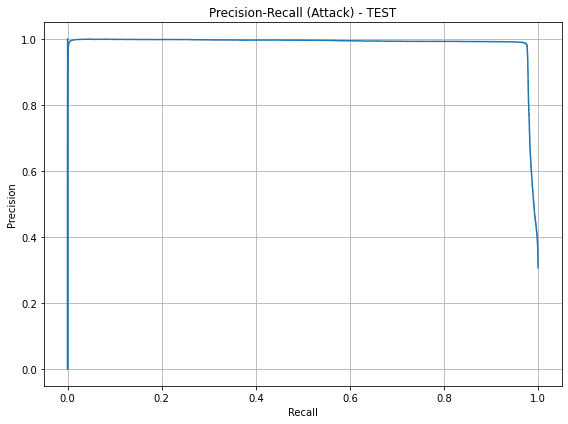

In [22]:
#Curva Precision-Recall (Attack) en TEST
import matplotlib.pyplot as plt

prec, rec, thr = precision_recall_curve(y_true, p1)

plt.figure(figsize=(8, 6))
plt.plot(rec, prec)
plt.title("Precision-Recall (Attack) - TEST")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.grid(True)
plt.savefig("Pipe2_pr_curve_test.png", dpi=300, bbox_inches="tight")  # <-- esto
plt.show()

In [13]:
import os, json
import numpy as np
import pandas as pd

os.makedirs("exports", exist_ok=True)

# Timestamp a nivel de flujo en TEST
ts_test_flow = df["Timestamp"].iloc[i_val:].reset_index(drop=True)

# ends por ventana (índice del último elemento)
ends = np.array(test_ds.starts) + WINDOW_SIZE - 1

# timestamp de predicción por ventana = timestamp del fin de ventana
ts_test_win = ts_test_flow.iloc[ends].reset_index(drop=True)


p_attack = p1.astype(float)  

out = pd.DataFrame({
    "pipeline": "p2_pca_gru_tcn",
    "timestamp": ts_test_win,
    "y_true": y_true.astype(int),
    "y_pred": y_pred.astype(int),
    "p_attack": p_attack,
    "window_start": np.array(test_ds.starts, dtype=int),
    "window_end": ends.astype(int),
    "window_size": int(WINDOW_SIZE),
    "stride": int(STRIDE),
})

out.to_parquet("exports/p2_test_preds.parquet", index=False)
print("Guardado:", "exports/p2_test_preds.parquet", "| shape:", out.shape)

meta = {
    "pipeline": "p2_pca_gru_tcn",
    "task": "binary",
    "split": "temporal",
    "train_frac": 0.70,
    "val_frac": 0.15,
    "test_frac": 0.15,
    "pca_components": int(X_train_pca.shape[1]),
    "gru_hidden": 64,
    "window_size": int(WINDOW_SIZE),
    "stride": int(STRIDE),
}
with open("exports/p2_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, default=str)
print("Guardado:", "exports/p2_meta.json")


Guardado: exports/p2_test_preds.parquet | shape: (84913, 9)
Guardado: exports/p2_meta.json


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
import torch
from torch.utils.data import DataLoader

# ==============================
# Permutation Importance (P2)
# ==============================
# Usa:
# - X_test_pca  (n_flows_test, D)
# - y_test      (n_flows_test,)
# - WINDOW_SIZE, STRIDE
# - encoder (congelado) + tcn_head (mejor estado ya cargado)
# Métrica: AP / PR-AUC para Attack en TEST

# --- Helper: construir dataset de ventanas desde arrays (igual que tu clase) ---
def make_window_starts(n, window_size, stride):
    return list(range(0, n - window_size + 1, stride))

class SeqWindowBinaryDataset_Array(torch.utils.data.Dataset):
    def __init__(self, X_pca, y_bin, window_size, stride):
        self.X = torch.tensor(X_pca, dtype=torch.float32)
        self.y = np.asarray(y_bin, dtype=np.int64)
        self.ws = window_size
        self.starts = make_window_starts(len(self.y), window_size, stride)

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, k):
        i = self.starts[k]
        x_win = self.X[i:i+self.ws]              # (T, D)
        y_win = int(self.y[i+self.ws-1])         # etiqueta del último flujo
        return x_win, y_win

@torch.no_grad()
def predict_p_attack_from_arrays(X_pca, y_flow, batch_size=256):
    ds = SeqWindowBinaryDataset_Array(X_pca, y_flow, WINDOW_SIZE, STRIDE)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    encoder.eval()
    tcn_head.eval()

    ys = []
    ps = []

    for xb, yb in dl:
        xb = xb.to(device)
        out_seq, _ = encoder(xb)                 # (B, T, H)
        logits = tcn_head(out_seq)               # (B, 2)
        p_attack = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        ys.append(yb.numpy())
        ps.append(p_attack)

    y_true_w = np.concatenate(ys)
    p_attack_w = np.concatenate(ps)
    return y_true_w, p_attack_w

# --- Baseline score ---
y_base, p_base = predict_p_attack_from_arrays(X_test_pca, y_test, batch_size=BATCH_SIZE)
base_ap = average_precision_score(y_base, p_base)
print("Baseline TEST AP (Attack):", base_ap)

# --- Permutation loop ---
D = X_test_pca.shape[1]
n_repeats = 3           # súbelo a 3 si quieres más estabilidad (más lento)
max_features = D        # o pon 20 si quieres probar rápido

rng = np.random.default_rng(42)

importances = np.zeros(D, dtype=float)

for j in range(min(D, max_features)):
    drops = []
    for r in range(n_repeats):
        Xp = X_test_pca.copy()
        col = Xp[:, j].copy()
        rng.shuffle(col)
        Xp[:, j] = col

        y_perm, p_perm = predict_p_attack_from_arrays(Xp, y_test, batch_size=BATCH_SIZE)
        ap_perm = average_precision_score(y_perm, p_perm)

        drops.append(base_ap - ap_perm)

    importances[j] = float(np.mean(drops))
    if (j + 1) % 5 == 0 or j == 0:
        print(f"Feature PC{j}: ΔAP={importances[j]:.6f}")

pi_df = pd.DataFrame({
    "pc": [f"PC{i}" for i in range(D)],
    "ap_drop": importances
}).sort_values("ap_drop", ascending=False)

print("\nTop 15 PCs por importancia (caída AP):")
display(pi_df.head(15))


Baseline TEST AP (Attack): 0.9866276152341078
Feature PC0: ΔAP=0.009733
Feature PC4: ΔAP=0.008037
Feature PC9: ΔAP=0.000001
Feature PC14: ΔAP=0.000717
Feature PC19: ΔAP=0.000559
Feature PC24: ΔAP=-0.000706

Top 15 PCs por importancia (caída AP):


,pc,ap_drop
0,PC0,0.009733
4,PC4,0.008037
5,PC5,0.002857
3,PC3,0.002492
22,PC22,0.002036
8,PC8,0.001441
7,PC7,0.001214
2,PC2,0.000831
14,PC14,0.000717
18,PC18,0.000634


In [16]:
print("len(y_test):", len(y_test))
print("len(y_pred):", len(y_pred))

len(y_test): 424581
len(y_pred): 84913


In [17]:
y_true, y_pred, p1 = predict_proba(test_loader)

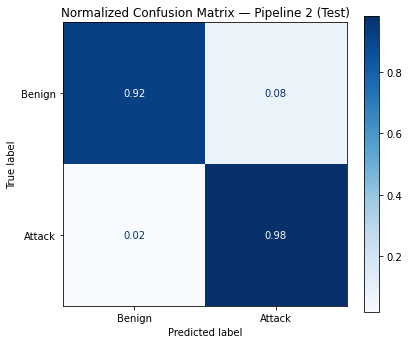

Confusion matrix (counts):
 [[53967  4859]
 [  543 25544]]


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Normalizada (como tu imagen: filas suman 1) ---
cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=["Benign", "Attack"]
)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
ax.set_title("Normalized Confusion Matrix — Pipeline 2 (Test)")
plt.tight_layout()
plt.savefig("cm_pipeline2_norm.png", dpi=300, bbox_inches="tight")
plt.show()

# --- (Opcional) No normalizada (conteos) ---
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Confusion matrix (counts):\n", cm)


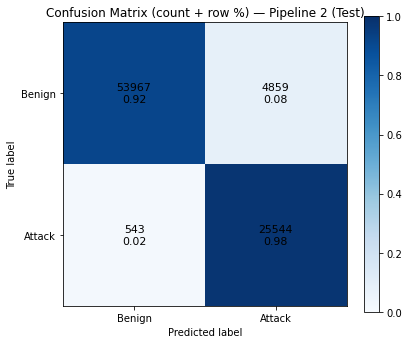

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm_counts_and_pct(y_true, y_pred, title, labels=("Benign", "Attack"),
                           normalize="true", savepath=None):
    # Counts
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    # Percentages
    cm_pct = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize=normalize)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm_pct, cmap="Blues", vmin=0, vmax=1)
    fig.colorbar(im, ax=ax)

    ax.set_xticks([0, 1], labels=labels)
    ax.set_yticks([0, 1], labels=labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # Text annotations: "count\npct"
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            pct = cm_pct[i, j]
            ax.text(j, i, f"{count}\n{pct:.2f}",
                    ha="center", va="center", fontsize=11)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# ---- Pipeline 2 (usa y_true, y_pred) ----
plot_cm_counts_and_pct(
    y_true, y_pred,
    title="Confusion Matrix (count + row %) — Pipeline 2 (Test)",
    labels=("Benign", "Attack"),
    normalize="true",
    savepath="cm_pipeline2_count_pct.png"
)
